# K. pneumoniae with MLP

In [1]:
# enable auto-reloading submodules
%reload_ext autoreload
%autoreload 2

# hidpi plots for retina displays
%config InlineBackend.figure_format = 'retina'

from sklearn.neural_network import MLPClassifier
from trainer import Trainer

## Training

In [2]:
drugs = [
    'Ciprofloxacin',
    'Ceftriaxone',
    'Cefepime',
    'Meropenem',
    'Tobramycin',
]

trainer = Trainer(
    pathogen='Klebsiella pneumoniae',
    # NOTE: there will be no true label in test data if you use too many folds
    n_splits=5,
    sites=['A'],
    years=[2015, 2016, 2017, 2018],
)

for d in drugs:
    trainer.fit(
        drug=d,
        model=MLPClassifier(
            alpha=0.0001,
            activation='relu',
            random_state=164,
            hidden_layer_sizes=[512, 256, 128],
            max_iter=200,
            # verbose=1,
            # early_stopping=True,
            # n_iter_no_change=20,
            # validation_fraction=0.1,
        )
    )

Loading Ciprofloxacin...
Training w/o SMOTE...
Fold 1/5...
AUC=0.6277078415945451, ACC=0.8537477148080439, f1=0.3846153846153847
Fold 2/5...
AUC=0.7292158405455023, ACC=0.8811700182815356, f1=0.563758389261745
Fold 3/5...
AUC=0.7231182795698925, ACC=0.8793418647166362, f1=0.5540540540540541
Fold 4/5...
AUC=0.6797141358510359, ACC=0.8738574040219378, f1=0.4888888888888889
Fold 5/5...
AUC=0.7686180804460374, ACC=0.9010989010989011, f1=0.6351351351351352
Training w/ SMOTE...
Fold 1/5...
AUC=0.6958562811434565, ACC=0.8756855575868373, f1=0.5142857142857142
Fold 2/5...
AUC=0.7059008654602674, ACC=0.8756855575868373, f1=0.5277777777777778
Fold 3/5...
AUC=0.7496590611067401, ACC=0.8903107861060329, f1=0.6000000000000001
Fold 4/5...
AUC=0.742840283241542, ACC=0.8957952468007313, f1=0.6013986013986014
Fold 5/5...
AUC=0.6939864595778574, ACC=0.8608058608058609, f1=0.4933333333333334
Loading Ceftriaxone...
Training w/o SMOTE...
Fold 1/5...
AUC=0.7661324939190156, ACC=0.8910369068541301, f1=0.6219

## Results Collection and Visualization

In [3]:
results = trainer.collect_results()
# export results to csv files
results.save_to('./results/kpn_mlp/')

### Bar Graph

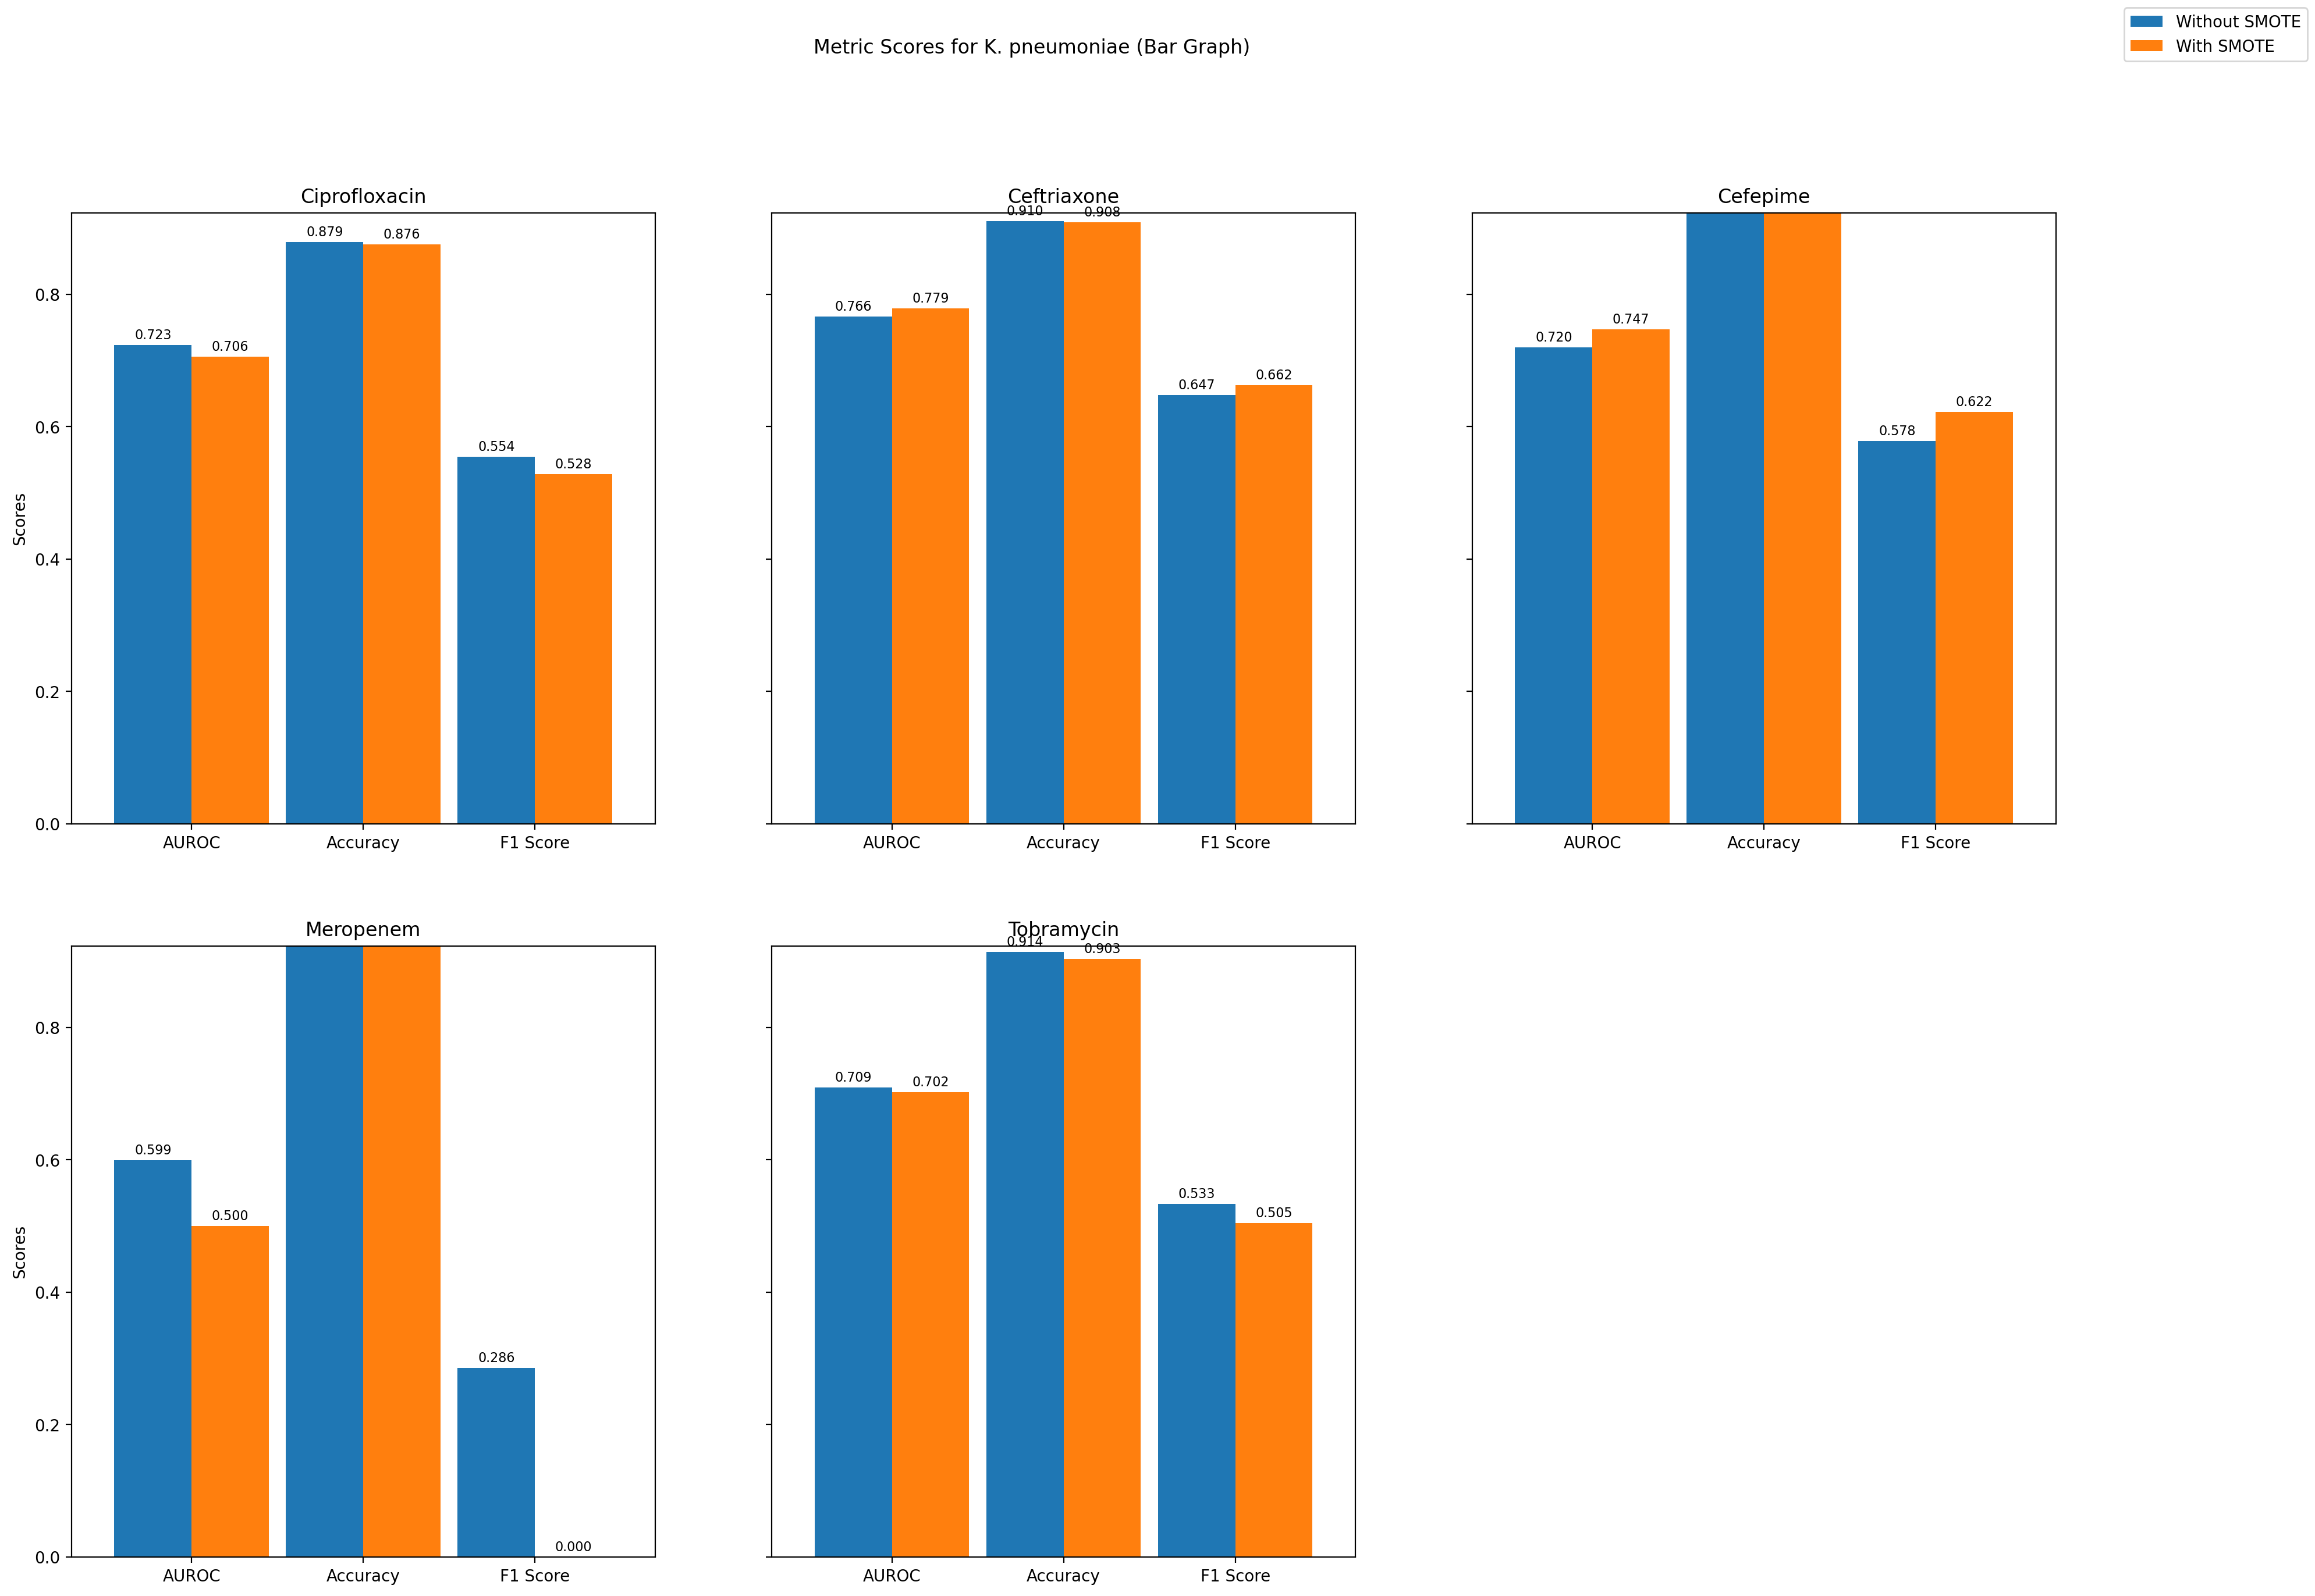

In [4]:
results.bar_plot(
    title='Metric Scores for K. pneumoniae (Bar Graph)',
    save_as='./results/kpn_mlp/bar.png',
    nrows=2,
    ncols=3,
    sharey=True,
    figsize=(22, 15),
)

### Box Graph

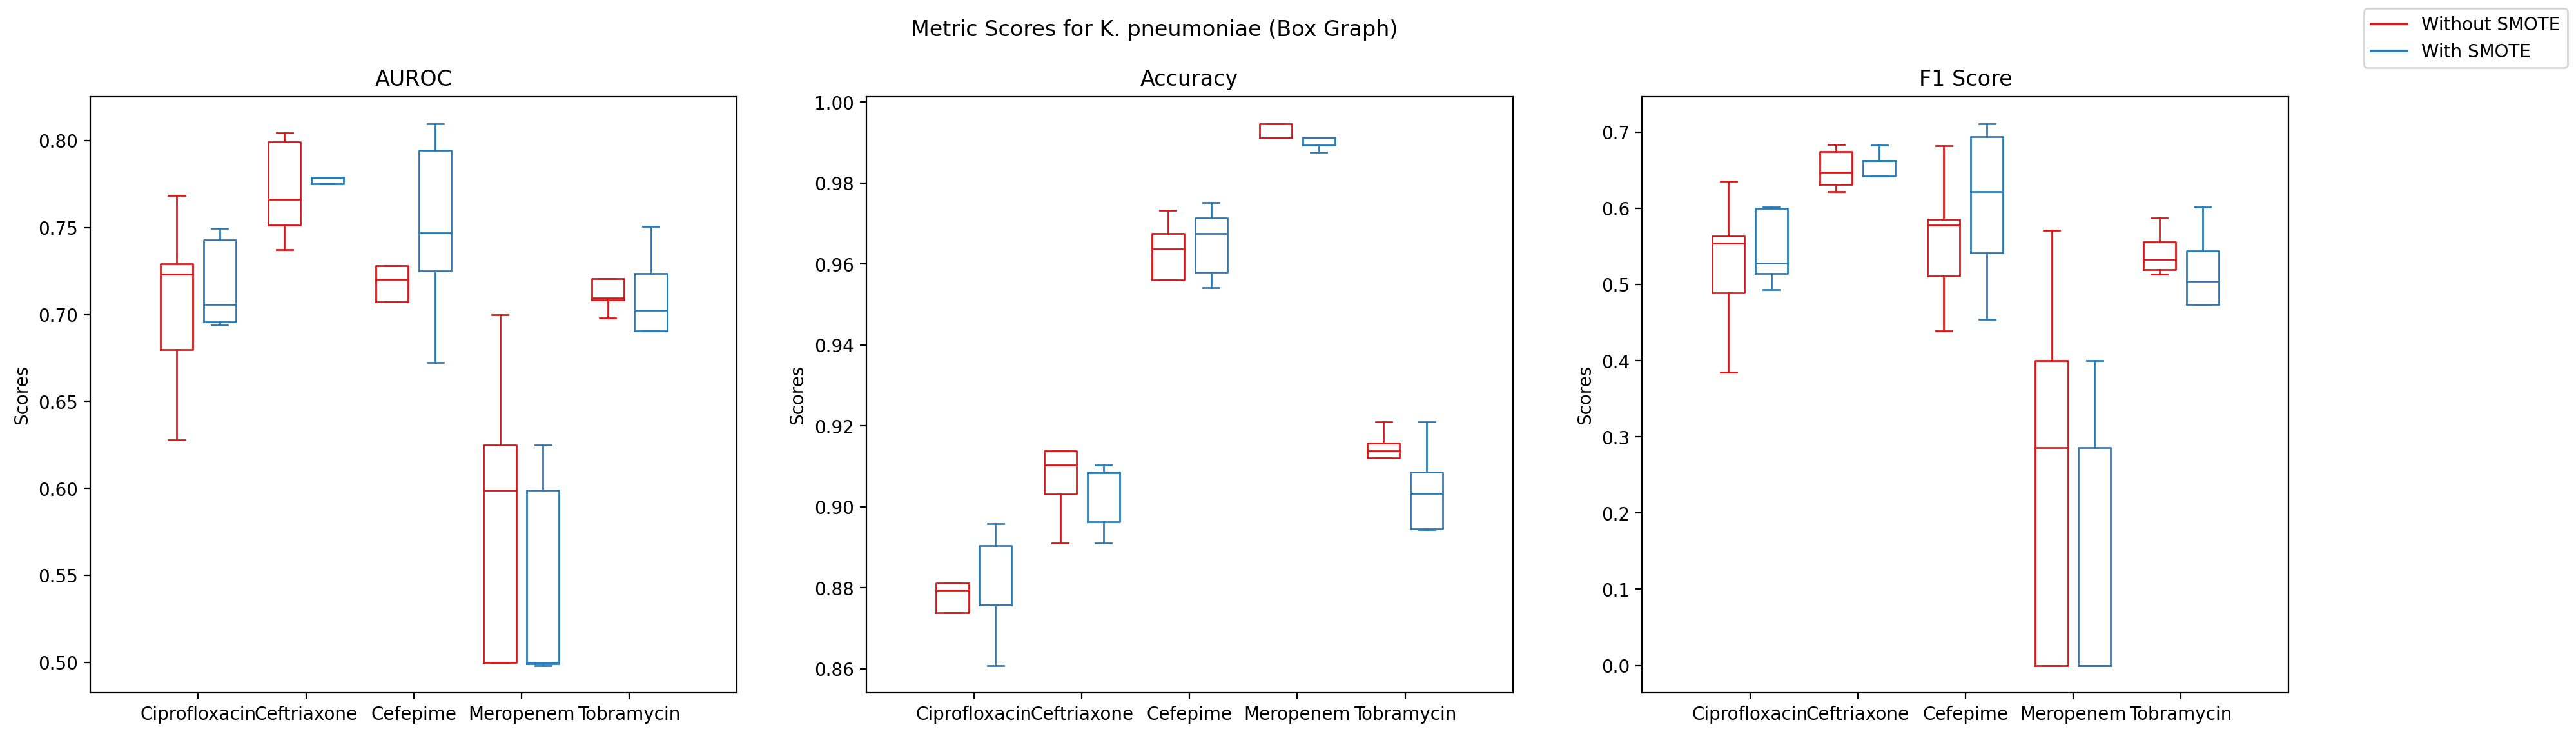

In [5]:
results.box_plot(
    title='Metric Scores for K. pneumoniae (Box Graph)',
    save_as='./results/kpn_mlp/box.png',
    nrows=1,
    ncols=3,
    # sharey=True,
    figsize=(22, 6),
)
